In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
 
from spacy.matcher import Matcher 
from spacy.tokens import Span 
 
import networkx as nx
 
import matplotlib.pyplot as plt
import tqdm as tqdm
 
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
news_data=pd.read_csv("/content/drive/MyDrive/FND Dataset/True.csv")
news_data['text'].sample(5)

18407    WASHINGTON (Reuters) - The U.S. State Department denied Russian assertions on Tuesday that U.S. officials had broken into residences at the Russian consulate in San Francisco, saying security offi...
19700    MOSCOW (Reuters) - The Kremlin said on Tuesday that possible supplies of lethal weapons to Ukraine by the United States will not promote stability in eastern Ukraine. Ukrainian President Petro Por...
7206     BERLIN (Reuters) - German Chancellor Angela Merkel said on Thursday she would announce at the appropriate moment whether she will run for a fourth term next year, adding “that is not today.”  She ...
16444    BEIJING (Reuters) - Military relations between China and the United States are a positive force in ties, and China wants to deepen mutual trust and cooperation, China s Defense Ministry said on Th...
16745    TOKYO (Reuters) - Prime Minister Shinzo Abe, buoyed by a huge election win for lawmakers who favor revising Japan s post-war, pacifist constitution, signal

In [ ]:
def get_entities(sent):
  ent1=""
  ent2=""

  prev_tok_dep=""    
  prev_tok_text=""

  prefix=""
  modifier=""

  
  for tok in nlp(sent):

    if tok.dep_ !="punct":
      if tok.dep_=="compound":
        prefix=tok.text
        if prev_tok_dep=="compound":
          prefix=prev_tok_text + " "+ tok.text
      
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prev_tok_dep == "compound":
          modifier = prev_tok_text + " "+ tok.text
      
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prev_tok_dep = ""
        prev_tok_text = ""      

      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      prev_tok_dep = tok.dep_
      prev_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [ ]:
pairs=[]
for i in news_data['text'][1].split("."):
  pairs.append(get_entities(i))

In [ ]:
pairs

[['Republicans', 'fiscal  script'],
 ['U.S. military', 'transgender  Pentagon'],
 ['Senior Mr. Mueller', 'job'],
 ['FBI Russia probe', 'Australian diplomat tip off'],
 ['Postal Service', 'much Amazon shipments'],
 ['White House White Congress', 'immigration'],
 ['Russia probe', ''],
 ['', '29 Approval rating'],
 ['', 'Twitter'],
 ['', 'today Senator elect challenge'],
 ['Jones', 'Moore challenge'],
 ['New York governor', 'federal tax overhaul'],
 ['', '28 Vanity Fair'],
 ['', 'Twitter'],
 ['he', 'new U.S. tax law'],
 ['Virginia officials', 'tied statehouse election'],
 ['U.S. lawmakers', 'Trump Tower meeting'],
 ['', '26 Hillary Clinton'],
 ['U.S. appeals court', 'voter fraud panel'],
 ['Treasury Secretary Mnuchin', 'wrapped horse manure'],
 ['Federal  judge', 'latest refugee restrictions'],
 ['U.S. memo', 'immigrant  court'],
 ['Trump travel ban', 'strong U.S. ties'],
 ['Trump', 'military  recruits'],
 ['Failed  vote', 'politics'],
 ['', 'government spending law'],
 ['Companies', 'new

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  matcher = Matcher(nlp.vocab)

  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in news_data['title'][:50]]
pd.Series(relations).value_counts()[:50]

Trump on                3
Factbox                 3
rejects                 3
says                    2
shakes                  1
senator                 1
suit on foreign         1
Trump                   1
bill until next         1
flip                    1
weakens                 1
launches                1
McConnell               1
sees                    1
question                1
prepare for             1
cut                     1
certified               1
have                    1
postpone                1
advance in              1
rally                   1
wants                   1
warning from            1
apply to                1
rules                   1
asks Trump              1
Alabama                 1
pressure                1
reports                 1
votes                   1
Mexico                  1
widens                  1
tells                   1
official                1
bills into              1
seek                    1
approves                1
helped by Au

In [ ]:
source = [i[0] for i in pairs[:50]]

# extract object
target = [i[1] for i in pairs[:50]]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

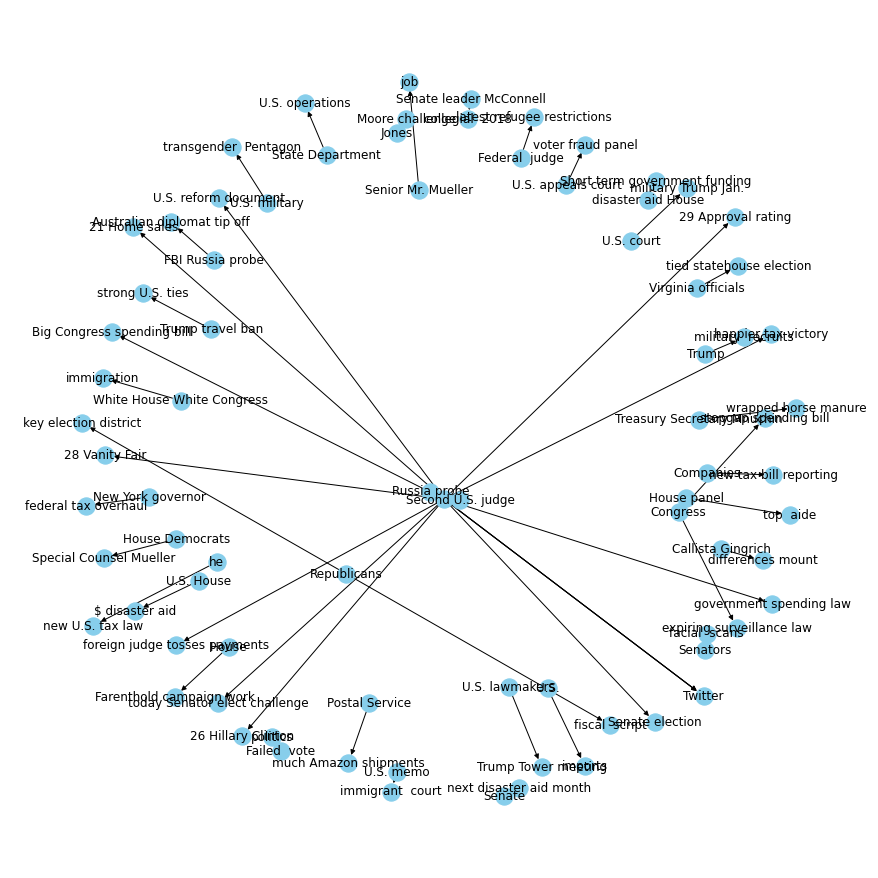

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

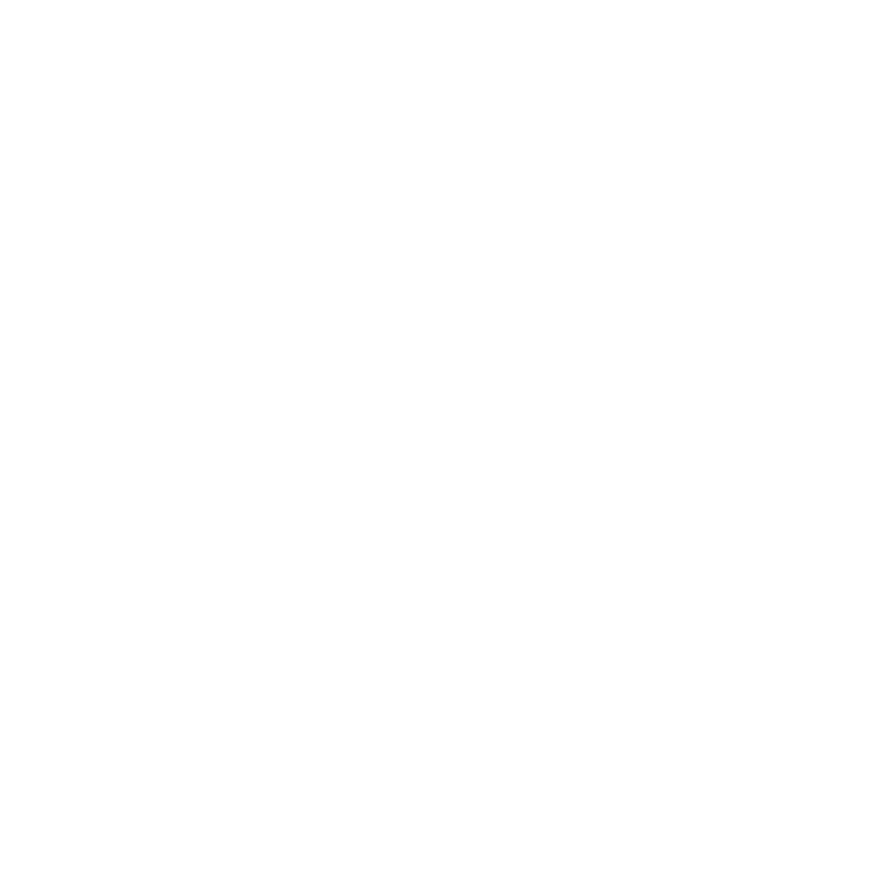

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()